## 算法实现-2

### 载入数据

In [1]:
import matplotlib
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

读入经过预处理的数据

In [2]:
train_path = "data/train_data_v1.csv"
train_data = pd.read_csv(train_path,sep=" ")
test_path = "data/test_data_v1.csv"
test_data = pd.read_csv(test_path,sep=" ")
data = train_data.copy(deep=True)

### 特征选择

选择作为特征的属性如choosed_attris所列出，根据检验推测二手车的使用时间与其价格应该成反比，所以计算regdate和createdate的差得到车辆的使用时间，也作为其中一个特征。

In [3]:
data['used_time'] = (pd.to_datetime(data['creatDates'], format='%Y-%m-%d', errors='coerce') - 
                            pd.to_datetime(data['regDates'], format='%Y-%m-%d', errors='coerce')).dt.days
choosed_attris = ["bodyType","brand","kilometer",
              'model', 'notRepairedDamage', 'power',
              'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
               'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 
              'regDate_year',
              'name_count','used_time']
train = data[choosed_attris]
label = data["price"]

In [4]:
train

,bodyType,brand,kilometer,model,notRepairedDamage,power,v_0,v_1,v_10,v_11,...,v_3,v_4,v_5,v_6,v_7,v_8,v_9,regDate_year,name_count,used_time
0,1.0,6,12.5,30.0,0.0,60,43.357796,3.966344,-2.881803,2.804097,...,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,2004,108,4385
1,2.0,1,15.0,40.0,0.0,0,45.305273,5.236112,-4.900482,2.096338,...,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,2003,29,4757
2,1.0,15,12.5,115.0,0.0,163,45.978359,4.823792,-4.846749,1.803559,...,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,2004,3,4382
3,0.0,10,15.0,109.0,0.0,193,45.687478,4.492574,-4.509599,1.285940,...,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,1996,2,7125
4,1.0,5,5.0,110.0,0.0,68,44.383511,2.031433,-1.896240,0.910783,...,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,2012,1,1531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,4.0,10,15.0,121.0,0.0,163,45.316543,-3.139095,1.988114,-2.983973,...,-0.736609,-1.505820,0.280264,0.000310,0.048441,0.071158,0.019174,2000,1,5772
149995,0.0,11,10.0,116.0,0.0,125,45.972058,-3.143764,1.839166,-2.774615,...,-2.366699,0.698012,0.253217,0.000777,0.084079,0.099681,0.079371,2009,1,2322
149996,1.0,11,6.0,60.0,0.0,90,44.733481,-3.105721,2.439812,-1.630677,...,-2.279091,1.423661,0.233353,0.000705,0.118872,0.100118,0.097914,2010,1,2003
149997,3.0,10,15.0,34.0,0.0,156,45.658634,-3.204785,2.075380,-2.633719,...,-1.179812,0.620680,0.256369,0.000252,0.081479,0.083558,0.081498,2006,1,3673


In [5]:
label

0         7.523481
1         8.188967
2         8.736007
3         7.783641
4         8.556606
            ...   
149994    8.682877
149995    9.159152
149996    8.922792
149997    8.517193
149998    8.455531
Name: price, Length: 149999, dtype: float64

将构建好的数据集划分为训练集<x_train, y_train>和验证集<x_train, y_train>两部分，并将划分前后的这些数据全部转储到文件中。

In [20]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.2)
joblib.dump(train, "dataset/train.csv") 
joblib.dump(label, "dataset/label.csv") 
joblib.dump(x_train, "dataset/x_train.csv") 
joblib.dump(x_test, "dataset/x_test.csv") 
joblib.dump(y_train, "dataset/y_train.csv") 
joblib.dump(y_test, "dataset/y_test.csv")

['dataset/y_test.csv']

### 构建模型

在最初实现中，使用回归决策树模型进行预测，但是最终的效果还是不够好。所以进一步测试使用随机森林分类器和构建预测模型。

随机森林属于Bagging类算法，在训练阶段，随机森林使用bootstrap采样从输入训练数据集中采集多个不同的子训练数据集来依次训练多个不同决策树；在预测阶段，随机森林将内部多个决策树的预测结果取平均得到最终的结果。

XGBoost算法特征分裂来生长一棵树，每一轮学习一棵树，其实就是去拟合上一轮模型的预测值与实际值之间的残差。当我们训练完成得到k棵树时，我们要预测一个样本的分数，其实就是根据这个样本的特征，在每棵树中会落到对应的一个叶子节点，每个叶子节点就对应一个分数，最后只需将每棵树对应的分数加起来就是该样本的预测值。

- 回归决策树

In [6]:
def train_decision_tree_regressor(x_train, y_train):
    dr = tree.DecisionTreeRegressor()
    dr.fit(x_train, y_train)
    return dr

- 随机森林回归器

In [7]:
def train_random_forest_regressor(x_train, y_train):
    #rfr = RandomForestRegressor(n_estimators=80, max_depth=25 )
    rfr = RandomForestRegressor(n_estimators=80,)
    rfr.fit(x_train, y_train)
    return rfr

- GBDT模型

In [8]:
def train_XGBRegressor(x_train, y_train):
    gbm= XGBRegressor()
    gbm.fit(x_train, y_train)
    return gbm

加载保存的x_train, y_train，训练模型

In [11]:
def load_dataset():
    paths = ["dataset/x_train.csv", "dataset/x_test.csv","dataset/y_train.csv", "dataset/y_test.csv"]
    x_train, x_test, y_train, y_test = [joblib.load(x) for x in paths]
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_dataset()

执行本目录下的[algo2.py](algo2.py)文件，开始训练模型，并将模型保存在models目录下。

In [11]:
if sys.argv[1] == "xgbt":
    drm = train_XGBRegressor(x_train, y_train)
    pkl_name = "XGBRegressor"
if sys.argv[1] == "tree":
    drm = train_decision_tree_regressor(x_train, y_train)
    pkl_name = "train_decision_tree_regressor"
if sys.argv[1] == "forest":
    drm = train_random_forest_regressor(x_train, y_train)
    pkl_name = "train_forest_regressor"
else:
    sys.exit(0)
t1 = time.time()
print("excute_time: %f"%round(t1 - t0, ndigits=4))
print("dumping model")
joblib.dump(drm, "models/"+pkl_name+".pkl") 

### 结果分析

载入训练后的模型，使用验证集<x_test,y_test>计算模型的MAE，MAE越小，说明模型预测得越准确。。

In [9]:
import joblib
dtr = joblib.load("models/train_decision_tree_regressor.pkl")
rfr = joblib.load("models/train_forest_regressor.pkl")
xgbr = joblib.load("models/XGBRegressor.pkl")

- 回归决策树

In [19]:
x_train, x_test, y_train, y_test = load_dataset()
predict_test = dtr.predict(x_test)
mae_result = []
print(mean_absolute_error(predict_test, y_test))
print(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))
mae_result.append(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))

0.1862874276297354
857.6127744304264


- 随机森林回归器

In [20]:
predict_test = rfr.predict(x_test)
print(mean_absolute_error(predict_test, y_test))
print(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))
mae_result.append(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))

0.1304358534662892
590.0747423926608


- GBDT模型

In [21]:
predict_test = xgbr.predict(x_test)
print(mean_absolute_error(predict_test, y_test))
print(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))
mae_result.append(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))

0.13869179402663728
652.1383889745077


#### 结果对比

<BarContainer object of 3 artists>

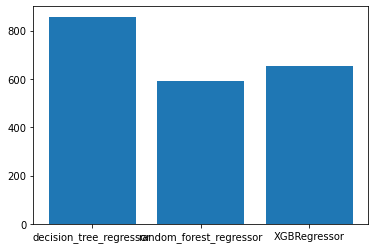

In [25]:
plt.bar(["decision_tree_regressor","random_forest_regressor","XGBRegressor"], mae_result,label="2")

可以看出，相比于决策树，随机森林回归器和GBDT模型的MAE都得到显示降低，模型的预测性能得到提高。

#### 得到最终的预测模型

最后，对随机森林回归树模型与xgbt回归模型进行简单的加权融合，计算MAE。

In [28]:
def Weighted_method(test_pre1,test_pre2,w=[1/2,1/2]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)
    return Weighted_result

x_train, x_test, y_train, y_test = load_dataset()
m1 = rfr
m2 = xgbr
predict_1 = m1.predict(x_test)
predict_2 = m2.predict(x_test)
predict_test = Weighted_method(predict_1, predict_2)
print(mean_absolute_error(predict_test, y_test))
print(mean_absolute_error(np.expm1(predict_test), np.expm1(y_test)))

0.12778741339762678
585.0242469211836


MAE有所减小。因此，最终的模型使用随机森林回归树模型与xgbt回归模型预测的均值作为二手车价格的预测值。

使用最终模型在测试集[data/test_data_v1.csv](data/test_data_v1.csv)进行预测。

In [32]:
test_path = "data/test_data_v1.csv"
test_data = pd.read_csv(test_path,sep=" ")
test_data['used_time'] = (pd.to_datetime(test_data['creatDates'], format='%Y-%m-%d', errors='coerce') - 
                            pd.to_datetime(test_data['regDates'], format='%Y-%m-%d', errors='coerce')).dt.days
test_data_features = test_data[["bodyType","brand","kilometer",
              'model', 'notRepairedDamage', 'power',
              'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
               'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 
               'regDate_year',
              'name_count','used_time']]
model = joblib.load("models/train_forest_regressor.pkl")
model2 = joblib.load("models/XGBRegressor.pkl")

#预测
p1 = model.predict(test_data_features)
p2 = model2.predict(test_data_features)
price = Weighted_method(p1, p2)

#生成用于提交的csv文件
output = pd.DataFrame()
output['SaleID'] = test_data.SaleID
output['price'] = np.expm1(price)
output.to_csv('output/submmit_stack.csv',index=False)

测试集预测结果的MAE为578.4769

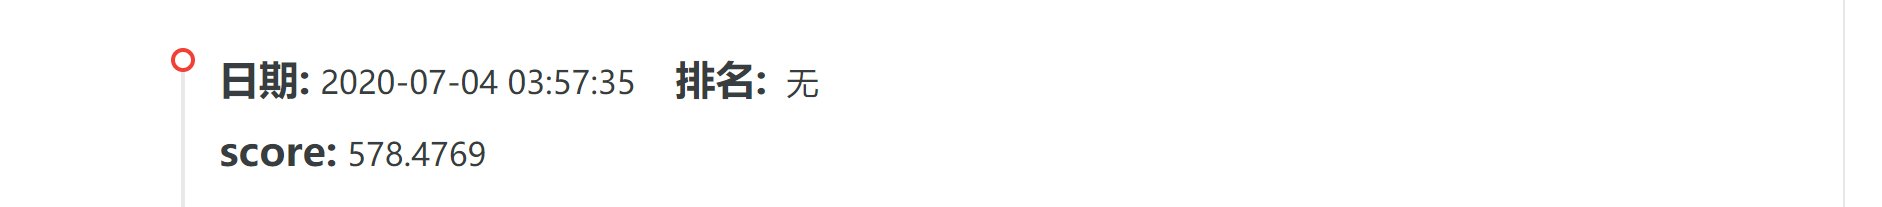